# FluA-2 and D2 H1-1/H3-1 mutational antigenic profiling _in_ _vivo_

## Overview:
In this analysis, we will analyze the deep sequencing data from a selection experiment performed using deep mutational scanning codon libraries of all possible single amino-acid in A/WSN/33 H1 HA. The selections were performed by Lauren Gentles and Jesse Bloom with the non-neutralizing antibodies [FluA-20](https://www.ncbi.nlm.nih.gov/pubmed/31100268) and [D2 H1-1/H3-1](https://www.ncbi.nlm.nih.gov/pubmed/27820605) (here referred to as D2) kindly supplied by James Crowe and and George Georgiou respectively. Antibodies were delived in 100ug dose to DBA/2J mice 2 hours prior to infected, and samples were collected at days 2 and 3 post-infection.

## Import Python packages

In [1]:
import glob
import os

from IPython.display import display, HTML

import matplotlib.pyplot as plt
plt.ion()

import pandas

import dmslogo
print(f"Using dmslogo version {dmslogo.__version__}")

import dms_tools2
from dms_tools2.ipython_utils import showPDF
print(f"Using dms_tools2 version {dms_tools2.__version__}")

# results will go in this directory
resultsdir = './results/' 
os.makedirs(resultsdir, exist_ok=True)
    
# CPUs to use, should not exceed the number you request with slurm
ncpus = 14

# do we use existing results or generate everything new?
use_existing = 'yes'

fastqdir = os.path.join(resultsdir, 'FASTQ_files/')
os.makedirs(fastqdir, exist_ok=True)
    
renumberedcountsdir = os.path.join(resultsdir, 'renumberedcounts')
os.makedirs(renumberedcountsdir, exist_ok=True)

Matplotlib is building the font cache using fc-list. This may take a moment.


Using dmslogo version 0.2.3
Using dms_tools2 version 2.6.1


## Process deep sequencing data

### Get information about samples
Here we define the samples by reading in a *.csv* file containing the selection type, library, replicate, and R1 path. We then combind the selection type, replicate, and the library to create the sample name. For example, the WSN library 1 replicate 1 selected with antibody FluA-20 for two days gets the name, 'FluA-20-Lib.1-day2_None'. We also include a mock unselected sample for comparison to identified enriched mutations in the FluA-20 selected sample. The WSN-plasmid encodes the wildtype HA sequence and will served as an error control in this analysis. There are two separate error control samples in this analysis since two different sequencing runs were required to produce the data.

In [2]:
samples = pandas.read_csv('data/samplelist.csv')
samples['name'] = samples.selection + '-' + samples.replicate

display(HTML(samples.to_html(index=False)))

selection,library,replicate,R1,name
FluA-20,Lib.1,day2-None,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190923_D00300_0825_BH3L23BCX3/Unaligned/Project_bloom_lab/Sample_WSN_FluA20_day2_None/WSN_FluA20_day2_None_GTCCGC_L001_R1_001.fastq.gz,FluA-20-day2-None
FluA-20,Lib.1,day2-Left,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190923_D00300_0825_BH3L23BCX3/Unaligned/Project_bloom_lab/Sample_WSN_FluA20_day2_Left/WSN_FluA20_day2_Left_GTGGCC_L001_R1_001.fastq.gz,FluA-20-day2-Left
FluA-20,Lib.1,day2-Right,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190923_D00300_0825_BH3L23BCX3/Unaligned/Project_bloom_lab/Sample_WSN_FluA20_day2_Right/WSN_FluA20_day2_Right_GTGAAA_L001_R1_001.fastq.gz,FluA-20-day2-Right
FluA-20,Lib.1,day3-None,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190923_D00300_0825_BH3L23BCX3/Unaligned/Project_bloom_lab/Sample_WSN_FluA20_day3_None/WSN_FluA20_day3_None_GTTTCG_L001_R1_001.fastq.gz,FluA-20-day3-None
FluA-20,Lib.1,day3-Left,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190923_D00300_0825_BH3L23BCX3/Unaligned/Project_bloom_lab/Sample_WSN_FluA20_day3_Left/WSN_FluA20_day3_Left_CAACTA_L001_R1_001.fastq.gz,FluA-20-day3-Left
FluA-20,Lib.1,day3-Right,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190923_D00300_0825_BH3L23BCX3/Unaligned/Project_bloom_lab/Sample_WSN_FluA20_day3_Right/WSN_FluA20_day3_Right_GAGTGG_L001_R1_001.fastq.gz,FluA-20-day3-Right
D2-H1-1-H3-1,Lib.1,day2-None,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190923_D00300_0825_BH3L23BCX3/Unaligned/Project_bloom_lab/Sample_WSN_D2_day2_None/WSN_D2_day2_None_CACCGG_L001_R1_001.fastq.gz,D2-H1-1-H3-1-day2-None
D2-H1-1-H3-1,Lib.1,day2-Left,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190923_D00300_0825_BH3L23BCX3/Unaligned/Project_bloom_lab/Sample_WSN_D2_day2_Left/WSN_D2_day2_Left_CACTCA_L001_R1_001.fastq.gz,D2-H1-1-H3-1-day2-Left
D2-H1-1-H3-1,Lib.1,day2-Right,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190923_D00300_0825_BH3L23BCX3/Unaligned/Project_bloom_lab/Sample_WSN_D2_day2_Right/WSN_D2_day2_Right_CACGAT_L001_R1_001.fastq.gz,D2-H1-1-H3-1-day2-Right
D2-H1-1-H3-1,Lib.1,day3-None,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190923_D00300_0825_BH3L23BCX3/Unaligned/Project_bloom_lab/Sample_WSN_D2_day3_None/WSN_D2_day3_None_CAGGCG_L001_R1_001.fastq.gz,D2-H1-1-H3-1-day3-None


### Run `dms2_batch_bcsubamp`
*dms2_batch_bcsubamp* aligns the sequencing reads and counts the frequency of mutations observed.

In [3]:
# file containing wildtype WSN HA sequence
refseq = './data/WSN-HA.fasta'

# define subamplicon alignment specifications
alignspecs = ' '.join(['1,285,36,37', 
                       '286,570,31,32',
                       '571,855,37,32',
                       '856,1140,31,36',
                       '1141,1425,29,33',
                       '1426,1698,40,43'])

# counts and alignments placed in this directory
countsdir = os.path.join(resultsdir, 'codoncounts')
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)
    
# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(samples[['name', 'R1']].to_html(index=False)))
samples[['name', 'R1']].to_csv(countsbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 170 \
        --fastqdir {fastqdir} \
        --ncpus {ncpus} \
        --use_existing {use_existing} 

print("Completed dms2_batch_bcsubamp.")

Here is the batch file that we write to CSV format to use as input:


name,R1
FluA-20-day2-None,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190923_D00300_0825_BH3L23BCX3/Unaligned/Project_bloom_lab/Sample_WSN_FluA20_day2_None/WSN_FluA20_day2_None_GTCCGC_L001_R1_001.fastq.gz
FluA-20-day2-Left,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190923_D00300_0825_BH3L23BCX3/Unaligned/Project_bloom_lab/Sample_WSN_FluA20_day2_Left/WSN_FluA20_day2_Left_GTGGCC_L001_R1_001.fastq.gz
FluA-20-day2-Right,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190923_D00300_0825_BH3L23BCX3/Unaligned/Project_bloom_lab/Sample_WSN_FluA20_day2_Right/WSN_FluA20_day2_Right_GTGAAA_L001_R1_001.fastq.gz
FluA-20-day3-None,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190923_D00300_0825_BH3L23BCX3/Unaligned/Project_bloom_lab/Sample_WSN_FluA20_day3_None/WSN_FluA20_day3_None_GTTTCG_L001_R1_001.fastq.gz
FluA-20-day3-Left,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190923_D00300_0825_BH3L23BCX3/Unaligned/Project_bloom_lab/Sample_WSN_FluA20_day3_Left/WSN_FluA20_day3_Left_CAACTA_L001_R1_001.fastq.gz
FluA-20-day3-Right,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190923_D00300_0825_BH3L23BCX3/Unaligned/Project_bloom_lab/Sample_WSN_FluA20_day3_Right/WSN_FluA20_day3_Right_GAGTGG_L001_R1_001.fastq.gz
D2-H1-1-H3-1-day2-None,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190923_D00300_0825_BH3L23BCX3/Unaligned/Project_bloom_lab/Sample_WSN_D2_day2_None/WSN_D2_day2_None_CACCGG_L001_R1_001.fastq.gz
D2-H1-1-H3-1-day2-Left,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190923_D00300_0825_BH3L23BCX3/Unaligned/Project_bloom_lab/Sample_WSN_D2_day2_Left/WSN_D2_day2_Left_CACTCA_L001_R1_001.fastq.gz
D2-H1-1-H3-1-day2-Right,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190923_D00300_0825_BH3L23BCX3/Unaligned/Project_bloom_lab/Sample_WSN_D2_day2_Right/WSN_D2_day2_Right_CACGAT_L001_R1_001.fastq.gz
D2-H1-1-H3-1-day3-None,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190923_D00300_0825_BH3L23BCX3/Unaligned/Project_bloom_lab/Sample_WSN_D2_day3_None/WSN_D2_day3_None_CAGGCG_L001_R1_001.fastq.gz



Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


### Look at summary plots
The `*_readstats.pdf` summary plot shows the number of reads that were retained or thrown away due to low quality barcodes. The black regions indicate reads that failed the Illumina filter.

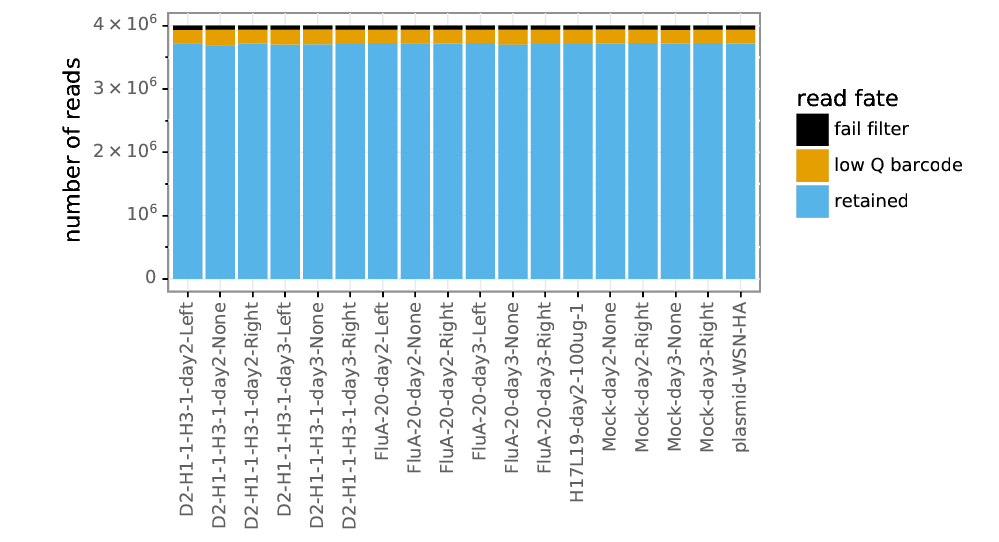

In [4]:
countsplotprefix = os.path.join(countsdir, 'summary')
showPDF(countsplotprefix + '_readstats.pdf', width=700)